In [46]:
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
path_root = "/home/shinesh/Documents/dataSample/"
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(128,128),color_mode="grayscale", batch_size=10000)

Found 1072 images belonging to 9 classes.


In [48]:
batches.class_indices

{'Gatak': 0,
 'Kelihos_ver1': 1,
 'Kelihos_ver3': 2,
 'Lollipop': 3,
 'Obfuscator.ACY': 4,
 'Ramnit': 5,
 'Simda': 6,
 'Tracur': 7,
 'Vundo': 8}

In [49]:
imgs, labels = next(batches)

In [51]:
imgs.shape

(1072, 128, 128, 1)

In [52]:
labels.shape

(1072, 9)

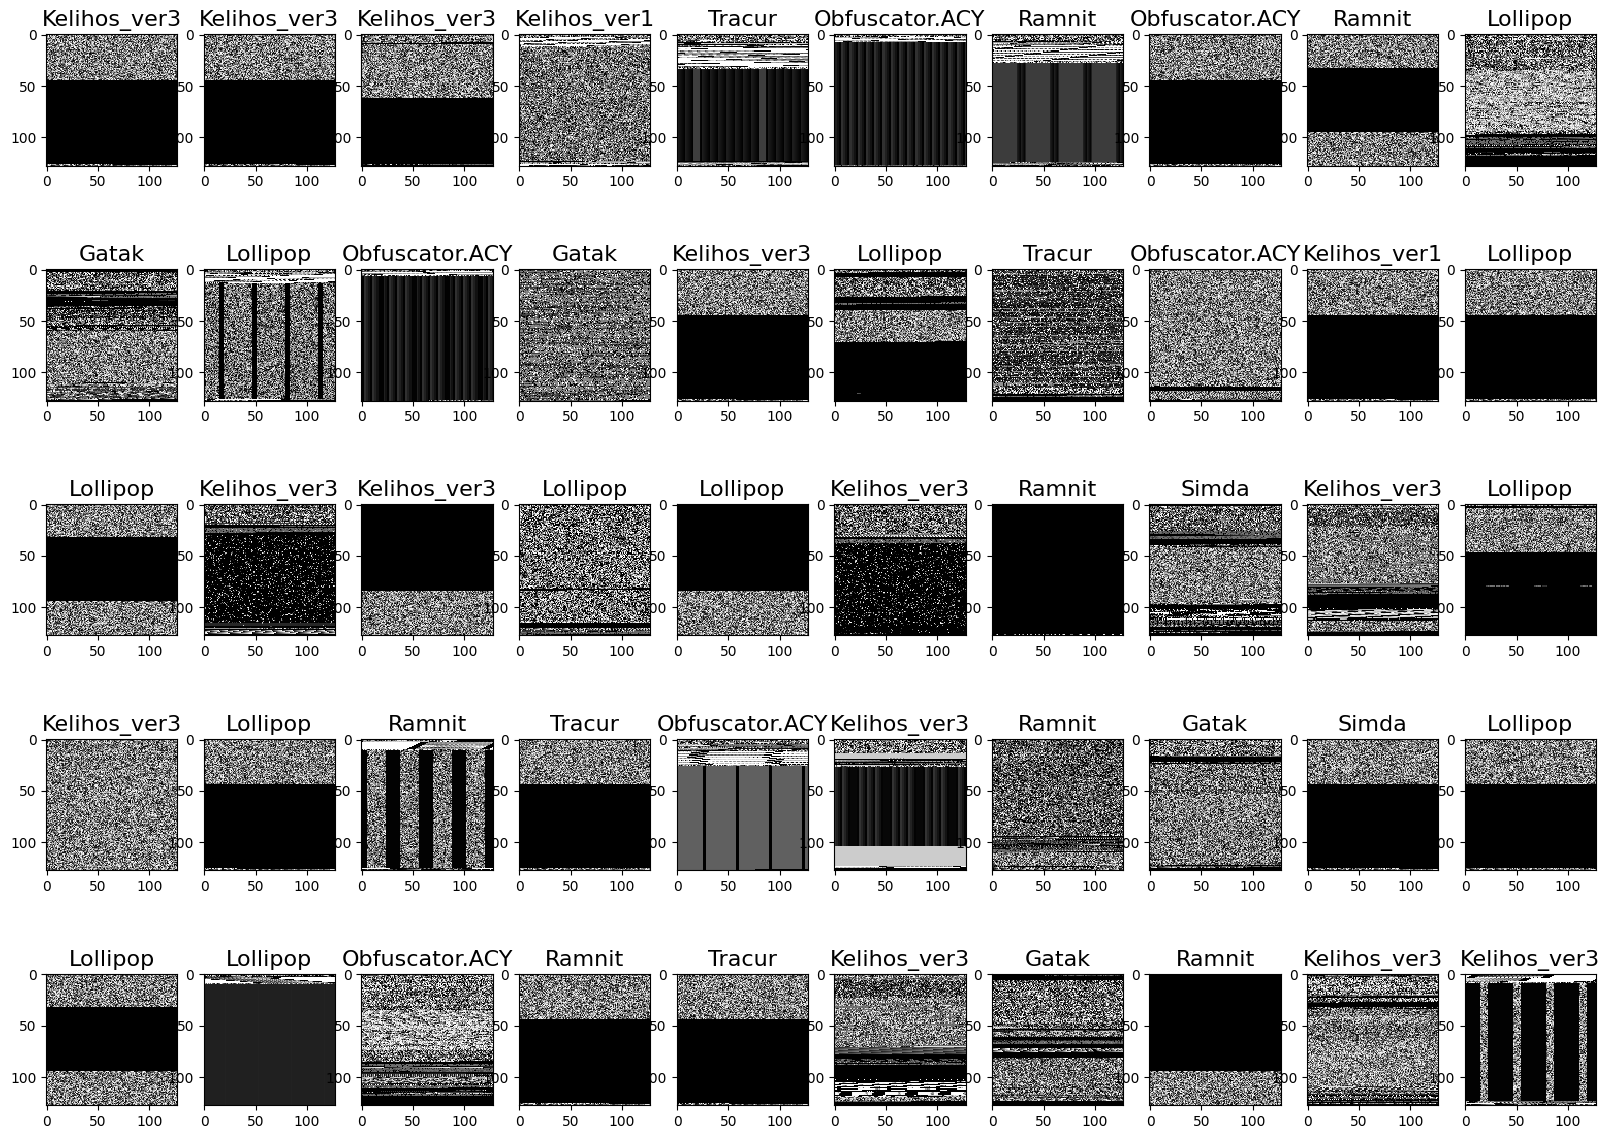

In [53]:
def plots(ims, figsize=(20, 30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] == 1:  # Check if images are grayscale
            ims = ims.squeeze(axis=-1)  # Remove the single channel dimension
    f = plt.figure(figsize=figsize)
    num_images = len(ims)
    cols = min(num_images, rows)
    for i in range(num_images):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('on')  # Turn off axis labels and ticks
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap='gray', interpolation=None if interp else 'none')  # Use grayscale cmap

# Usage
plots(imgs[:50], titles=labels[:50])


In [54]:
classes = batches.class_indices.keys()

In [55]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 9 artists>

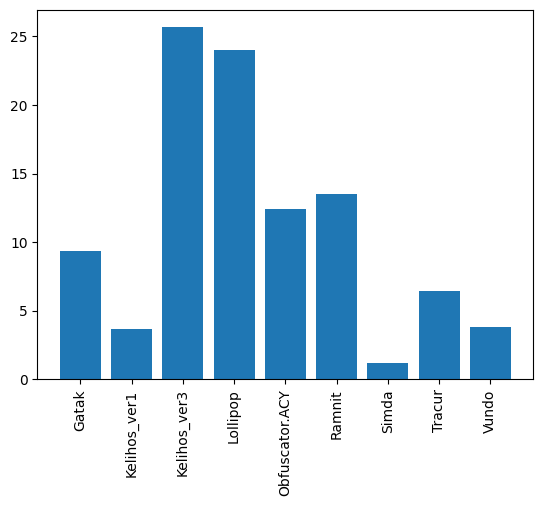

In [56]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.0,labels, test_size=0.3)

In [58]:
X_train.shape

(750, 128, 128, 1)

In [59]:
X_test.shape

(322, 128, 128, 1)

In [60]:
y_train.shape

(750, 9)

In [61]:
y_test.shape

(322, 9)

In [62]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
#warnings off


In [63]:
num_classes = 9

In [64]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(50, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(128,128,1)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    Malware_model.add(Dropout(0.25))
    # Local Response Normalization
    Malware_model.add(BatchNormalization())
    
    Malware_model.add(Conv2D(70, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    Malware_model.add(Dropout(0.25))
    # Local Response Normalization
    Malware_model.add(BatchNormalization())
    
    Malware_model.add(Conv2D(70, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    Malware_model.add(Dropout(0.25))
    
    # Local Response Normalization
    Malware_model.add(BatchNormalization())
    
    Malware_model.add(Flatten())
    
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [67]:
Malware_model = malware_model()

In [68]:
Malware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 50)      1300      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 123, 123, 50)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 123, 123, 50)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 123, 123, 50)     200       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 121, 121, 70)      31570     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 120, 120, 70)    

In [69]:
y_train.shape

(750, 9)

In [ ]:
from sklearn.model_selection import StratifiedKFold

num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_per_fold = []

y_train_multiclass = np.argmax(y_train, axis=1)  # Convert multilabel to multiclass

for fold, (train_indices, test_indices) in enumerate(kfold.split(X_train, y_train_multiclass), 1):
    print(f"Fold {fold}:")
    Malware_model = malware_model()

    X_train_fold, X_test_fold = X_train[train_indices], X_train[test_indices]
    y_train_fold, y_test_fold = y_train[train_indices], y_train[test_indices]  # Use integer labels

   
    Malware_model.fit(X_train_fold, y_train_fold, epochs=60, batch_size=64, verbose=1)
    _, accuracy = Malware_model.evaluate(X_test_fold, y_test_fold, verbose=0)
    accuracy_per_fold.append(accuracy)

Fold 1:
Epoch 1/60
10/10 [==============================] - 81s 7s/step - loss: 60.0171 - accuracy: 0.1383
Epoch 2/60
10/10 [==============================] - 75s 7s/step - loss: 38.5195 - accuracy: 0.2250
Epoch 3/60
10/10 [==============================] - 76s 8s/step - loss: 25.2630 - accuracy: 0.3183
Epoch 4/60
10/10 [==============================] - 76s 8s/step - loss: 16.4663 - accuracy: 0.3767
Epoch 5/60
10/10 [==============================] - 76s 8s/step - loss: 14.7047 - accuracy: 0.4000
Epoch 6/60
10/10 [==============================] - 75s 7s/step - loss: 8.2794 - accuracy: 0.4750
Epoch 7/60
10/10 [==============================] - 76s 7s/step - loss: 6.3706 - accuracy: 0.5050
Epoch 8/60
10/10 [==============================] - 76s 8s/step - loss: 5.6526 - accuracy: 0.5167
Epoch 9/60
10/10 [==============================] - 75s 7s/step - loss: 4.3196 - accuracy: 0.5533
Epoch 10/60
10/10 [==============================] - 75s 8s/step - loss: 3.1945 - accuracy: 0.5983
Epoch 

In [ ]:
#y_train_new = np.argmax(y_train, axis=1)

In [ ]:


# Print individual fold accuracies
for fold, accuracy in enumerate(accuracy_per_fold, 1):
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

# Calculate mean and standard deviation of accuracies
mean_accuracy = accuracy_per_fold.mean()
std_accuracy = accuracy_per_fold.std()
print(f"\nMean Accuracy: {mean_accuracy:.4f}")
print(f"Accuracy Standard Deviation: {std_accuracy:.4f}")



In [25]:
y_train_multiclass

array([0, 8, 0, ..., 7, 5, 3], dtype=int64)

In [46]:
history = Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60)

Epoch 1/60
190/190 [==============================] - 848s 4s/step - loss: 0.1696 - accuracy: 0.9946 - val_loss: 50.4614 - val_accuracy: 0.6040
Epoch 2/60
190/190 [==============================] - 831s 4s/step - loss: 0.1457 - accuracy: 0.9965 - val_loss: 11.2801 - val_accuracy: 0.8273
Epoch 3/60
190/190 [==============================] - 834s 4s/step - loss: 0.0638 - accuracy: 0.9972 - val_loss: 9.1518 - val_accuracy: 0.8891
Epoch 4/60
190/190 [==============================] - 831s 4s/step - loss: 0.2359 - accuracy: 0.9933 - val_loss: 143.3681 - val_accuracy: 0.4167
Epoch 5/60
190/190 [==============================] - 852s 4s/step - loss: 0.4160 - accuracy: 0.9895 - val_loss: 16.6986 - val_accuracy: 0.8338
Epoch 6/60
190/190 [==============================] - 843s 4s/step - loss: 0.6077 - accuracy: 0.9908 - val_loss: 72.2616 - val_accuracy: 0.5342
Epoch 7/60
190/190 [==============================] - 837s 4s/step - loss: 0.5389 - accuracy: 0.9891 - val_loss: 18.9829 - val_accuracy:

In [ ]:
scores = Malware_model.evaluate(X_test, y_test)

In [ ]:
print('Final CNN accuracy: ', scores[1])

In [ ]:
print(accuracy)

In [69]:
import numpy as np
import pandas as pd

In [70]:
y_pred_prob = Malware_model.predict(X_test_fold, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

In [71]:
y_pred

array([0, 8, 3, ..., 5, 1, 3], dtype=int64)

In [72]:
y_test2 = np.argmax(y_test, axis=1)


In [73]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

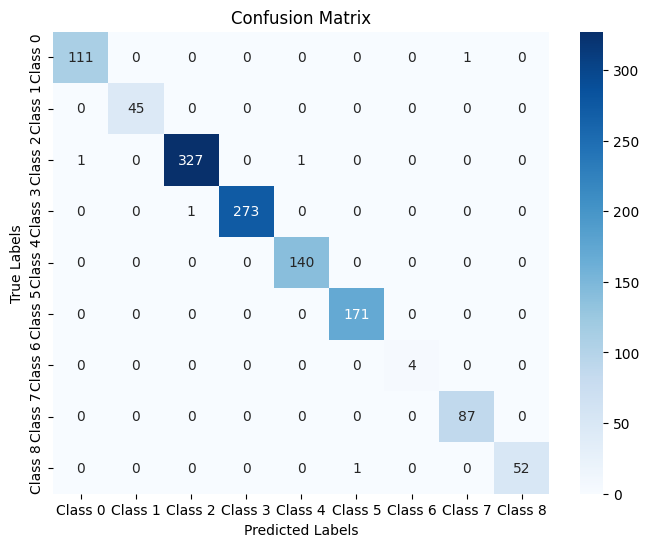

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Make predictions on the current test fold (X_test_fold)
y_pred_prob = Malware_model.predict(X_test_fold, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels (y_test_fold) to multiclass format
y_test_fold2 = np.argmax(y_test_fold, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_fold2, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(cm.shape[0])], yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy for each class
#class_accuracy = {}
#num_classes = cm.shape[0]
#for class_label in range(num_classes):
  #  true_positive = cm[class_label, class_label]
 #   total_samples = np.sum(cm[class_label, :])
#    class_accuracy[f'Class {class_label}'] = true_positive / total_samples

# Print accuracy for each class
#print("Accuracy for each class:")
#for class_label, acc in class_accuracy.items():
 #   print(f"{class_label}: {acc:.4f}")


In [89]:

# Calculate training accuracy
_, train_accuracy = Malware_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
_, val_accuracy = Malware_model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.9959
Validation Accuracy: 0.9010


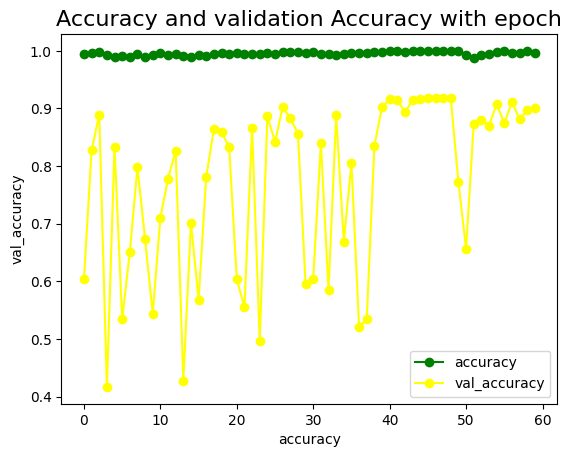

In [88]:
plt.title('Accuracy and validation Accuracy with epoch', fontsize=16)
plt.plot(history.history['accuracy'],marker='o',color='green',label='accuracy')
plt.plot(history.history['val_accuracy'],marker='o',color='yellow',label='val_accuracy')
plt.xlabel('accuracy')
plt.ylabel('val_accuracy')
plt.legend()
plt.show()

82/82 [==============================] - 171s 2s/step


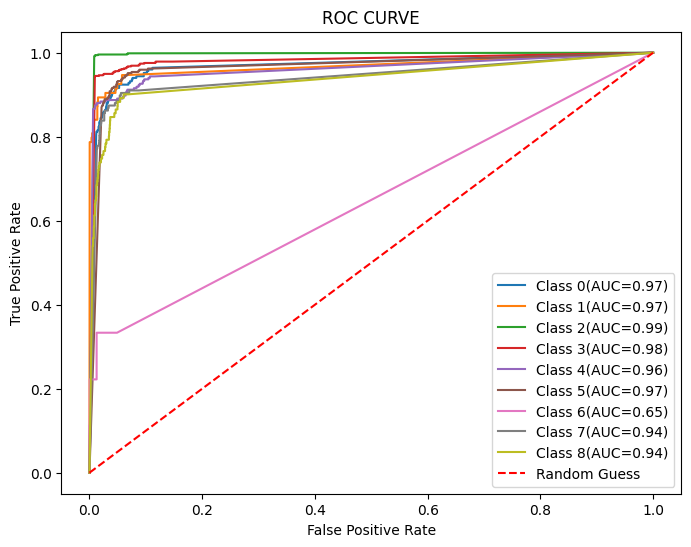

In [92]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
y_pred_prob = Malware_model.predict(X_test)
plt.figure(figsize = (8,6))
for i in range(num_classes):
    fpr,tpr,_= roc_curve(y_test[:,i],y_pred_prob[:,i])
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label='Class %d(AUC=%0.2f)'%(i,roc_auc))

plt.plot([0,1],[0,1],color='red',linestyle='--',label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc='lower right')
plt.show()